## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras._tf_keras.keras import layers
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras._tf_keras.keras.losses import SparseCategoricalCrossentropy
from keras._tf_keras.keras.callbacks import EarlyStopping

## Set Constant Values

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

## Download or load the dataset 

In [3]:
training = "datasets/Lesser Known Fruits/train/"
testing = "datasets/Lesser Known Fruits/test/"

## Image Preprocessing

### Create Dataset for train,test,validation

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 13120 files belonging to 41 classes.
Using 10496 files for training.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testing,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 3280 files belonging to 41 classes.
Using 2624 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 13120 files belonging to 41 classes.
Using 2624 files for validation.


In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['abiu', 'acai', 'acerola', 'ackee', 'ambarella', 'barberry', 'camu_camu', 'cempedak', 'cherimoya', 'chico', 'cluster_fig', 'cupuacu', 'damson', 'feijoa', 'finger_lime', 'goumi', 'hawthorn', 'hog_plum', 'jaboticaba', 'jambul', 'jocote', 'kaffir_lime', 'kumquat', 'lablab', 'langsat', 'mabolo', 'mangosteen', 'medlar', 'mock_strawberry', 'morinda', 'oil_palm', 'otaheite_apple', 'pawpaw', 'prikly_pear', 'quince', 'redcurrant', 'salak', 'taxus_baccata', 'ugli_fruit', 'white_currant', 'yali_pear']


## Visualize the data

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Configure the dataset for performance

In [9]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Standardize the data

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99101675


## Resize and Rescale

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(0.1 / 256)
])

## Data Augmentation

In [13]:
data_augmentation  = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

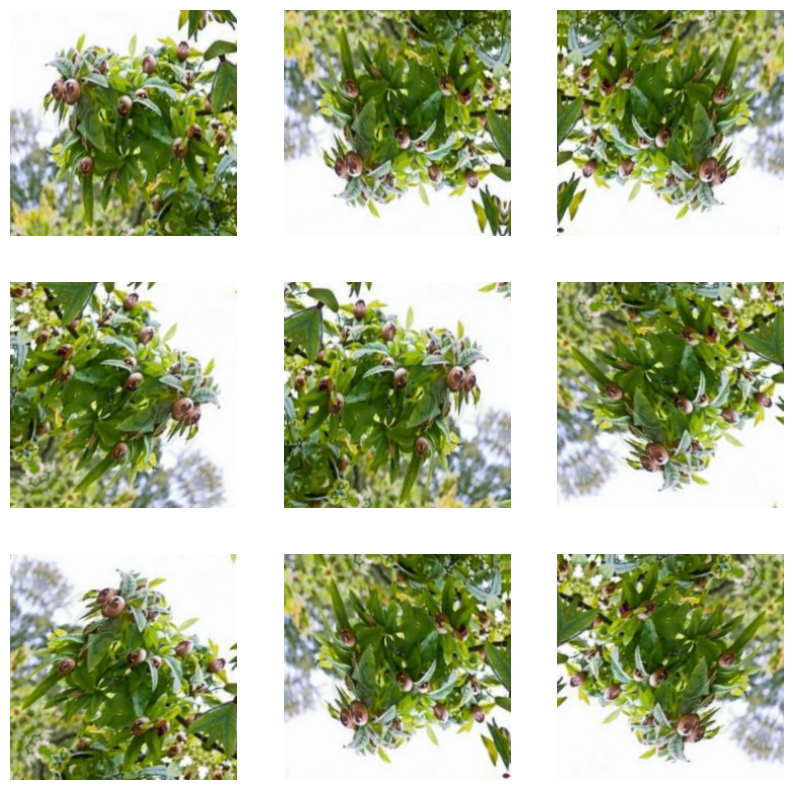

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Define the EarlyStopping callback

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your goal
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# DenseNet Model Implementation

In [17]:
from keras._tf_keras.keras.applications import DenseNet121
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [18]:
model_dense = Sequential()
resize_and_rescale
model_dense.add(base_model)
model_dense.add(Flatten())
model_dense.add(Dense(256,activation='relu'))
model_dense.add(Dropout(0.5))
model_dense.add(BatchNormalization())
model_dense.add(Dense(num_classes,activation='sigmoid'))
model_dense.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,894,377 (75.89 MB)

 Trainable params: 12,856,361 (49.04 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [19]:
model_dense.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [20]:
epochs = 5
history = model_dense.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1179s 4s/step - accuracy: 0.0965 - loss: 3.6041 - val_accuracy: 0.2302 - val_loss: 2.9880
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1147s 3s/step - accuracy: 0.1976 - loss: 2.9868 - val_accuracy: 0.2889 - val_loss: 2.7900
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1150s 4s/step - accuracy: 0.2220 - loss: 2.8469 - val_accuracy: 0.3201 - val_loss: 2.5428
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1206s 4s/step - accuracy: 0.2386 - loss: 2.7359 - val_accuracy: 0.3136 - val_loss: 2.5426
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 1188s 4s/step - accuracy: 0.2632 - loss: 2.6482 - val_accuracy: 0.3548 - val_loss: 2.4490
Restoring model weights from the end of the best epoch: 5.


Evaluate the model

In [21]:
model_dense.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.3698 - loss: 2.3265


[2.365295171737671, 0.3601371943950653]

Visualize training accuracy and loss

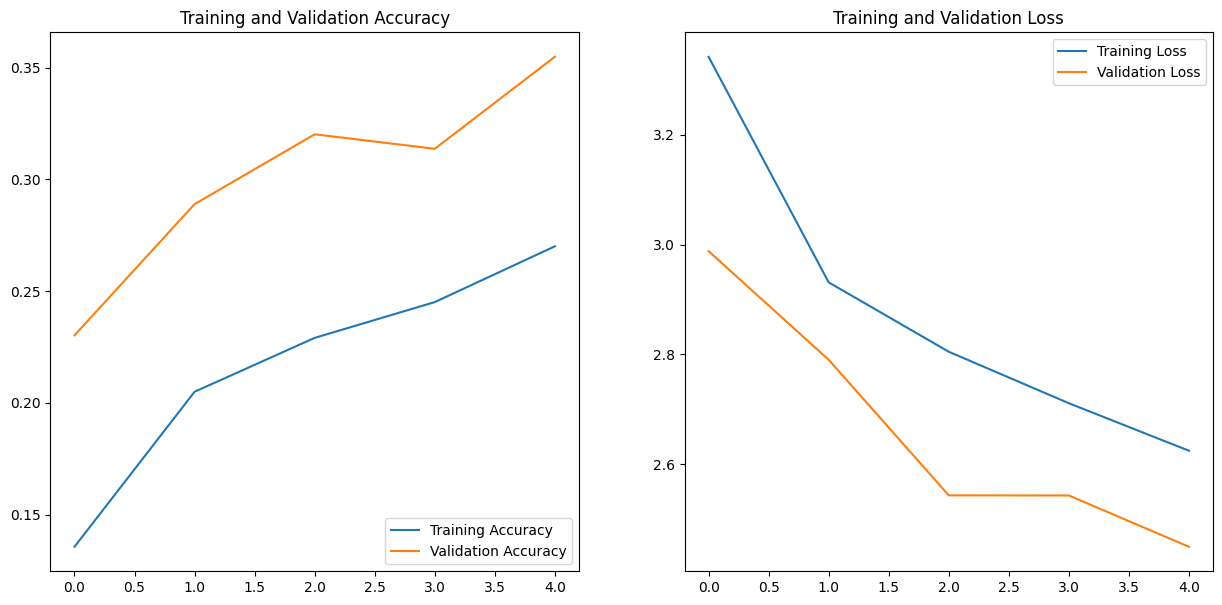

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the model

In [23]:
model_dense.save('Model DenseNet.keras')

# VGG19 Model Implementation

In [17]:
from keras._tf_keras.keras.applications import VGG19
base_vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_vgg.trainable = False

In [18]:
model_vgg = Sequential()
resize_and_rescale
model_vgg.add(base_vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(256,activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(BatchNormalization())
model_vgg.add(Dense(num_classes,activation='sigmoid'))
model_vgg.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,458,729 (100.93 MB)

 Trainable params: 6,433,833 (24.54 MB)

 Non-trainable params: 20,024,896 (76.39 MB)

In [19]:
model_vgg.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [20]:
epochs = 10
history = model_vgg.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4093s 12s/step - accuracy: 0.2086 - loss: 3.1440 - val_accuracy: 0.4970 - val_loss: 1.8764
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4289s 13s/step - accuracy: 0.4521 - loss: 2.0500 - val_accuracy: 0.5777 - val_loss: 1.5460
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4306s 13s/step - accuracy: 0.5051 - loss: 1.8027 - val_accuracy: 0.6197 - val_loss: 1.3806
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4304s 13s/step - accuracy: 0.5389 - loss: 1.6695 - val_accuracy: 0.6254 - val_loss: 1.3552
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4261s 13s/step - accuracy: 0.5675 - loss: 1.5647 - val_accuracy: 0.6421 - val_loss: 1.3058
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4298s 13s/step - accuracy: 0.5589 - loss: 1.5275 - val_accuracy: 0.6418 - val_loss: 1.2917
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4292s 13s/step - accuracy: 0.5695 - loss: 1.4991 - val_accuracy: 0.6494 - val_loss: 1.3203
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 4283s 13s/step - accuracy: 0.5976 - loss: 1

Evaluate the model

In [21]:
model_vgg.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 852s 10s/step - accuracy: 0.6882 - loss: 1.1164


[1.1483765840530396, 0.6821646094322205]

Visualize training accuracy and losses

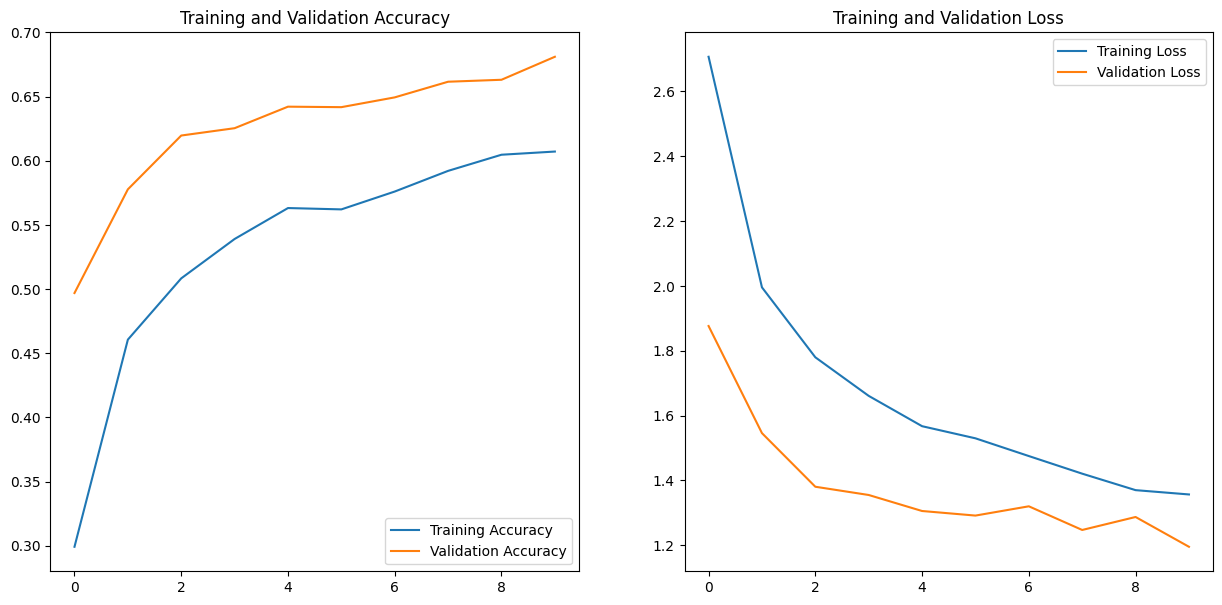

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the model

In [24]:
model_vgg.save('Model VGG19.keras')

# EfficientNet Model Implemantation

Import Base Model

In [29]:
from keras._tf_keras.keras.applications.efficientnet_v2 import EfficientNetV2B0
base_eff = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_eff.trainable = False

Add connected layers to base model

In [30]:
model_eff = Sequential()
resize_and_rescale
model_eff.add(base_eff)
model_eff.add(Flatten())
model_eff.add(Dense(256,activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(BatchNormalization())
model_eff.add(Dense(num_classes,activation='sigmoid'))
model_eff.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 41)             │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,987,449 (83.88 MB)

 Trainable params: 16,067,625 (61.29 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

Compile the model

In [31]:
model_eff.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Train the model

In [32]:
epochs = 10
history = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.3295 - loss: 2.6306 - val_accuracy: 0.7290 - val_loss: 0.9860
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.6401 - loss: 1.3069 - val_accuracy: 0.7698 - val_loss: 0.8239
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.6891 - loss: 1.0825 - val_accuracy: 0.7893 - val_loss: 0.7340
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.7083 - loss: 0.9747 - val_accuracy: 0.7957 - val_loss: 0.7072
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.7318 - loss: 0.9015 - val_accuracy: 0.8102 - val_loss: 0.6621
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - accuracy: 0.7539 - loss: 0.8308 - val_accuracy: 0.8152 - val_loss: 0.6443
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.7483 - loss: 0.8267 - val_accuracy: 0.8194 - val_loss: 0.6188
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.7690 - loss: 0.7753 - val_accu

Evaluate the Model

In [33]:
model_eff.evaluate(test_ds)

82/82 ━━━━━━━━━━━━━━━━━━━━ 66s 800ms/step - accuracy: 0.8391 - loss: 0.5419


[0.5631535649299622, 0.8334603905677795]

# Visualize training accuracy and losses

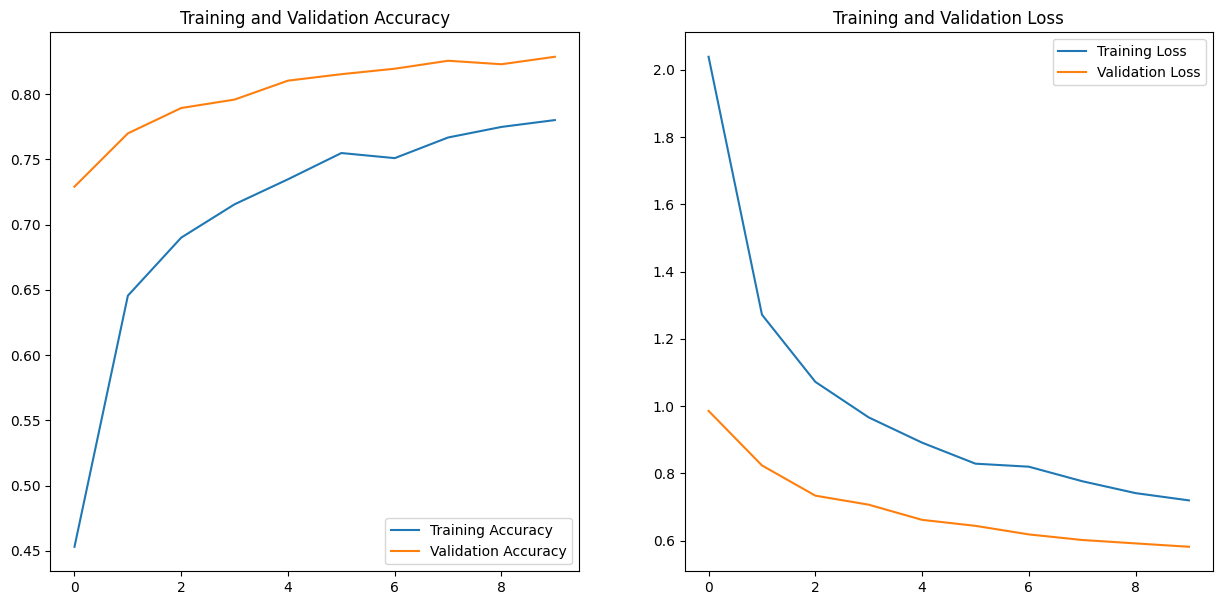

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the Model

In [35]:
model_eff.save('Model EfficientNet.keras')